# B3 - Best Model Evaluation PTB Dataset - XGBoost

## 1. Imports

In [7]:
import os 
from typing import Dict, Optional
import random 

# Evaluate the fitted MIT-trained XGBoost on the entire PTB dataset (train + val)
from src.utils.preprocessing import prepare_ptbdb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np


from src.utils import eval_model, evaluate_model
from src.visualization import plot_confusion_matrix
from src.utils.model_saver import create_model_saver

# external 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import loguniform, randint, uniform
import numpy as np
import re
import json

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Samplers

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from src.utils.preprocessing import (
    _normalize_sampling_method_name,
    _SAMPLING_REGISTRY
)


In [8]:
print("\n" + "="*80)
print("Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)")
print("="*80)

# Load PTB split (both train and test)
# validation is left out to compare 
ptb_dir = "/home/christianm/Projects/Repos/heartbeat_classification/data/processed/ptb"
X_ptb_train = pd.read_csv(f"{ptb_dir}/X_ptb_train.csv").values
y_ptb_train = pd.read_csv(f"{ptb_dir}/y_ptb_train.csv").iloc[:, 0].values.astype(int)
X_ptb_train_sm = pd.read_csv(f"{ptb_dir}/X_ptb_train_sm.csv").values
y_ptb_train_sm = pd.read_csv(f"{ptb_dir}/y_ptb_train_sm.csv").iloc[:, 0].values.astype(int)
X_ptb_test = pd.read_csv(f"{ptb_dir}/X_ptb_test.csv").values
y_ptb_test = pd.read_csv(f"{ptb_dir}/y_ptb_test.csv").iloc[:, 0].values.astype(int)
X_ptb_val = pd.read_csv(f"{ptb_dir}/X_ptb_val.csv").values
y_ptb_val = pd.read_csv(f"{ptb_dir}/y_ptb_val.csv").iloc[:, 0].values.astype(int)
X_ptb_full = np.vstack([X_ptb_train, X_ptb_test, X_ptb_val])
y_ptb_full = np.concatenate([y_ptb_train, y_ptb_test, y_ptb_val])

print("PTB dataset")
print(f"\tTraining size: {X_ptb_train.shape}, {y_ptb_train.shape}")
print(f"\tTraining SMOTE size: {X_ptb_train_sm.shape}, {y_ptb_train_sm.shape}")
print(f"\tTest Size: {X_ptb_test.shape}, {y_ptb_test.shape}")
# print(f"\tVal Size: {X_ptb_val.shape}, {y_ptb_val.shape}")


Evaluating MIT-trained 5-class XGBoost mapped to binary on full PTB (train+val)
PTB dataset
	Training size: (9308, 187), (9308,)
	Training SMOTE size: (13438, 187), (13438,)
	Test Size: (2909, 187), (2909,)


## 2. Constants & Param Spaces

In [9]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

PARAMS = {
    "n_estimators": 500,
    "max_depth": 9,
    "learning_rate": 0.2,
    "subsample": 0.7,
    "colsample_bytree": 0.9,
    "reg_alpha": 0.2,
    "reg_lambda": 0.05,
    "min_child_weight": 5,
    "gamma": 0.0,
}

## 3. Run

In [13]:
model = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="logloss",
    **PARAMS
)



In [14]:

# --- evaluation sets for learning curve ---
eval_set = [(X_ptb_train_sm, y_ptb_train_sm), (X_ptb_test, y_ptb_test)]

# --- fit model with eval_set to record progress ---
model.fit(
    X_ptb_train_sm, y_ptb_train_sm,
    eval_set=eval_set,
    verbose=False
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [15]:
# --- classification report on validation set ---
y_pred = model.predict(X_ptb_test)

prec_macro_full, rec_macro_full, f1_macro_full, ptb_f1_per_class = precision_recall_fscore_support(
    y_ptb_test, y_pred, average="macro", zero_division=0
)

print(f"F1-Macro: {f1_macro_full:.4f}")
print(f"Precision-Macro: {prec_macro_full:.4f}")
print(f"Recall-Macro: {rec_macro_full:.4f}")


print("\nClassification Report (Validation Set):")
print(classification_report(y_ptb_test, y_pred, digits=4))

F1-Macro: 0.9730
Precision-Macro: 0.9739
Recall-Macro: 0.9721

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9639    0.9580    0.9609       809
           1     0.9838    0.9862    0.9850      2100

    accuracy                         0.9783      2909
   macro avg     0.9739    0.9721    0.9730      2909
weighted avg     0.9783    0.9783    0.9783      2909



In [17]:
# --- extract evaluation history and plot ---
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

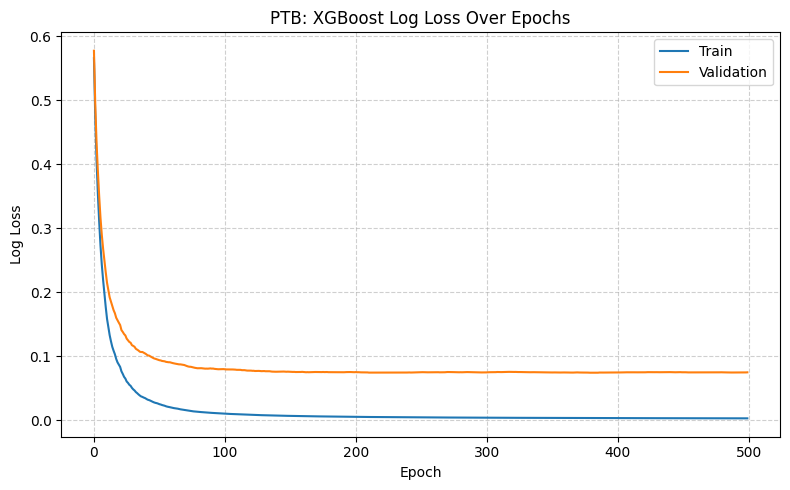

In [18]:
# --- extract evaluation history and plot ---
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(8, 5))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.title('PTB: XGBoost Log Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

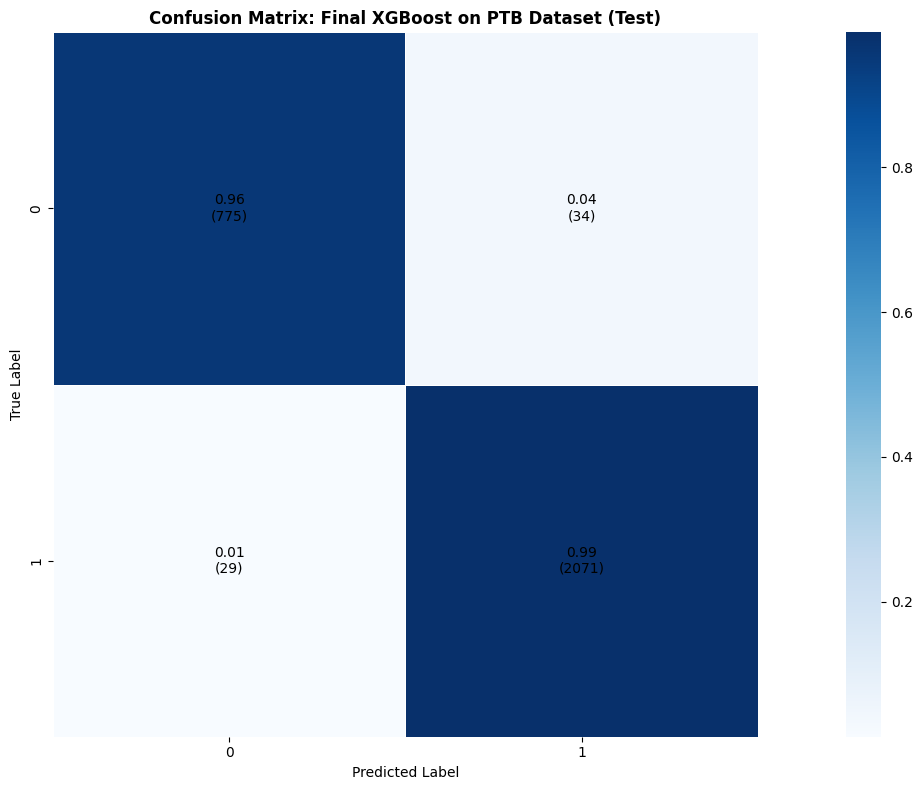

In [19]:
mit_labels = np.unique(np.concatenate([y_ptb_train_sm, y_ptb_test]))

mit_confusion = confusion_matrix(y_ptb_test, y_pred, labels=mit_labels)

class_names=[0, 1]

plot_confusion_matrix(y_ptb_test, y_pred, normalize=True, 
                         class_names=class_names, figsize=(18, 8), 
                         cmap='Blues', title='Confusion Matrix: Final XGBoost on PTB Dataset (Test)')
plt.show()